In [ ]:
# Base libraries
from collections import namedtuple, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable, Any
import numpy as np
import pandas as pd
import random
import pickle
import os
from tqdm import tqdm

# ML libraries
import torch

# Local imports
from env import Env
from agents.random_agent import RandomAgent
from agents.deep_q_agent import DeepQAgent
from agents.cql_agent import CQLAgent
from agents.minimax_agent import MinimaxAgent
import utils
import transformer_utils

# Fix random seed
utils.seed_everything()

# Import Transformers
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

In [ ]:
'''2 Options: 
        Generate Trajectories now
        Load existing Trajectories from a file
'''
GENERATE_TRAJECTORIES =  False #Set if you want to load from file or generate them here

# NOTE: Filename style: {agent_name}{input_params}_vs_{opponent_name}{input_params}_num{NUM_TRAJ}.pkl
file_to_load_from = '100k_minimax_02.pkl' #Define file from where to load the trajectories
file_to_store_to = '100k_random_traces.pkl' #Define file to where we should store the generated trajectories

AGENT = 1
OPPONENT = 2
# Number of created trajectories
NUM_TRAJ = 100_000

In [ ]:


if GENERATE_TRAJECTORIES:
    # Generate T_offline (offline Trajectories for the offline initialization of the replay buffer)
    # NOTE: alternative would be to initialize with either Random Trajs, or with Traj.s from DQN Agent / CQL Agent
    # NOTE: Corresponding paper: https://arxiv.org/pdf/2202.05607.pdf

    
    offline_trajectories = []

    #Initialize Environment and Agent
    env = Env()
    # agent = MinimaxAgent(env, depth=2, epsilon=0.2, player=1)
    # opponent = MinimaxAgent(env, depth=2, epsilon=0.2, player=2)
    agent = MinimaxAgent(env, depth=2, epsilon=1.0, player=1)
    opponent = MinimaxAgent(env, depth=2, epsilon=1.0, player=2)

    agent_won = 0
    agent_lost = 0

    for i in tqdm(range(0, NUM_TRAJ)):

        # Initialize other variables
        finished = -1

        #Initialize fields for trajectory
        states = []
        actions = []
        rewards = []
        dones = []

        # Make it random who gets to start the game
        # Set to true during the episode
        agent_start = random.choice([True, False])
        # Run one episode of the game
        while finished == -1:
            # Agent makes a turn
            if agent_start:
                state = env.get_state()
                #action = agent.act(state)
                action = agent.act(env.field)
                valid, reward, finished = agent.env.step(action, AGENT)
                #env.render_pretty()
                
                
                # Update current Trajectory
                #Flatten the state to be a 42-entry 1 dimensional array
                states.append(np.ravel(state))
                actions.append(action)
                rewards.append(reward)

                if finished != -1:
                    break

            else:
                agent_start = True

            # Opponent makes their turn
            #action = opponent.act(env.get_state_inverted())
            action = opponent.act(env.field)
            valid, _, finished = opponent.env.step(action, OPPONENT)

            if finished != -1: 
                if finished == OPPONENT:
                    #TODO this is hacky, if this happens the opponent won and we need to set the last reward for the agent..
                    rewards[-1] = -1
                break

        # The Flag if the Episode is finished is False for n-1 steps and True for the last step obviously..
        dones = ([False] * (len(rewards)-1)) + [True]
    
        assert len(states) == len(actions)
        assert len(actions) == len(rewards)
        assert len(dones) == len(rewards)
        length = len(states)
        RTGs = transformer_utils.calculate_RTG(rewards)
        traj = [length, states, actions, rewards, RTGs, dones]
        offline_trajectories.append(traj)

        #Keep track of statistics
        if finished == 1:
            agent_won+=1
        elif finished == 2:
            agent_lost+=1

        if i % NUM_TRAJ/3 == 0:
            print(f"Episode: {i}, RTG (start) : {RTGs[0]}, length: {length}, reward end: {rewards[-1]}, done: {dones[-1]}")
            print(f"Score: Agent {agent_won} - {agent_lost} Opponent")
            env.render_pretty()
            # print(traj)
        # if i % 100 == 0:
        #     print(i)

        env.reset()
        
    # Final score
    print(f"Score: Agent {agent_won} - {agent_lost} Opponent. There were {NUM_TRAJ - agent_won - agent_lost} Ties")

    # Sort offline buffer such that the order is descending in RTGs
    # [4][0] is the first RTG of the trajectory
    sorted_offline_trajectories = sorted(offline_trajectories, key=lambda x: x[4][0], reverse = True)


    #TODO: We currently only use one side of the table for generating trajectories, we could generate twice as many by also storing the trajectories from the "enemys POV"

if GENERATE_TRAJECTORIES:
    # HERE WE STORE TRAJECTORIES THAT WE PRODUCED ABOVE, OR ALREADY PRODUCED EARLIER!

    #Safety mechanism, to show if this specific file we want to write to doesn't already exist, and we lose our data.
    #NOTE: just comment this check out if you want to overwrite a file..
    if os.path.exists('trajectories/' + file_to_store_to):
        raise FileExistsError(f"File {file_to_store_to} already exists!")
    
    #Create Trajectories folder if in-existent
    if not os.path.exists('trajectories'):
        os.makedirs('trajectories')
    # Store data within specified file
    with open("trajectories/" + file_to_store_to, 'wb') as f:
        pickle.dump(sorted_offline_trajectories, f)

else:
    #Check if the given file exists
    if not os.path.exists('trajectories/' + file_to_load_from):
        raise FileExistsError(f"File {file_to_load_from} doesn't exist!")
    
    #Load Trajectories from specified file:
    with open('trajectories/' + file_to_load_from, 'rb') as f:
        sorted_offline_trajectories = pickle.load(f)


In [ ]:
print(sorted_offline_trajectories[-2])

In [ ]:
# convert the actions inside the "sorted_offline_trajectories"
print(sorted_offline_trajectories[-1])

#test_traj = [[4, 4, [1,2,3,4]]]

for i in range(len(sorted_offline_trajectories)):
    traj = sorted_offline_trajectories[i]
    actions = traj[2]
    new_actions = []
    for a in actions:
        new_action = [0,0,0,0,0,0,0]
        new_action[a] = 1
        new_actions.append(new_action)
    sorted_offline_trajectories[i][2] = new_actions

print(sorted_offline_trajectories[-1])




In [ ]:
# We have a dataset containing all the offline collected data
# Using this tutorial: https://huggingface.co/blog/train-decision-transformers
# We convert the dataset into data ready for the decision transformer
FRACTION = 0.7
N = int(FRACTION * NUM_TRAJ)
dataset = sorted_offline_trajectories[:N]
lengths = [x[0] for x in dataset]
max_episode_length = max(lengths)
print(f"Maximum Episode length: {max_episode_length}")
print(len(dataset))

# Constants represent the position of the value within a trajectory-array
# trajectory structure in the dataset: traj = [length, states, actions, rewards, RTGs, dones]
LENGTH = 0
STATES = 1
ACTIONS = 2
REWARDS = 3
RTGs = 4
DONES = 5

class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 21 #subsets of the episode we use for training
    state_dim: int = 42  # size of state space
    act_dim: int = 7  # size of action space
    max_ep_len: int = 42 # max episode length in the dataset TODO: is this the correct value?
    #scale: float = 1000.0  # normalization of rewards/returns
    n_traj: int = N # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = 7
        self.state_dim = 42
        self.dataset = dataset
        self.n_traj = len(dataset)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(np.arange(self.n_traj), size=batch_size, replace=True)
        
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # Select trajectory at given index
            feature = self.dataset[int(ind)]
            #set si randomly to start somewhere in the sequence (but at least max_len steps before the end..)
            length = self.dataset[ind][LENGTH]
            if length <= self.max_len:
                si = 0
            else:
                # we should just start from the end then, because we have sparse rewards...
                #si = random.randint(0, length - self.max_len)
                #NOTE: this case should never occur anyway if we work with a window size of the maximum possible episode length..
                si = max(0, length - self.max_len - 1)

            # get sequences from dataset
            s.append(np.array(feature[STATES][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature[ACTIONS][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature[REWARDS][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature[DONES][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature[REWARDS][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1)
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        # Converting
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # This is how the trajectories are returned for the transformer to learn with them
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

In [ ]:
# # This code is 1:1 from the Huggingface blog, don't know if the loss is correct for our usecase
# class TrainableDT(DecisionTransformerModel):
#     def __init__(self, config):
#         super().__init__(config)

#     def forward(self, **kwargs):
#         output = super().forward(**kwargs)
#         # add the DT loss
#         action_preds = output[1]
#         action_targets = kwargs["actions"]
#         attention_mask = kwargs["attention_mask"]
#         act_dim = action_preds.shape[2]
#         action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
#         action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
#         #print(f"action_preds: {action_preds} and action_targets: {action_targets}, length: {len(action_preds)}")
        
#         #loss = torch.mean((action_preds - action_targets) ** 2)
#         criterion = torch.nn.CrossEntropyLoss()
#         loss = criterion(action_preds, action_targets)

#         return {"loss": loss}

#     def original_forward(self, **kwargs):
#         return super().forward(**kwargs)

In [ ]:
#Training Arguments
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=30, # 120
    per_device_train_batch_size=64, # 64
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

# Initialize and then train the model
collator = DecisionTransformerGymDataCollator(dataset)
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = transformer_utils.TrainableDT(config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

#trainer.train()

In [ ]:
print(dataset[-1])
# traj structure: [length, states, actions, rewards, RTGs, dones]

In [38]:
# store the model trained above...
# trainer.save_model("dt_model/final_minimax_offline")

# Path to your saved model
model_path = 'dt_model/final_random_offline'

# Load the model
model = transformer_utils.TrainableDT.from_pretrained(model_path)

In [ ]:
# util function, given a 7 elemenent array corresponding to an action, gives the int of the corresponding taken action :)


# another util function that returns index of maximum in array



In [ ]:
# # This cell is supposed to evaluate the Decision Transformer against a MinimaxAgent (or RandomAgent) for a fixed amount of Episodes
# model = model.to("cpu")
# env = Env()
# max_ep_len = max_episode_length
# print(f"Maximum Episode Length is {max_ep_len}")
# device = "cpu"
# TARGET_RETURN = 2
# NUM_EVAL = 100

# opponent = MinimaxAgent(env, depth=2, epsilon=0.0, player=2)

# games_won = 0
# games_lost = 0

# for ii in range(0,NUM_EVAL):

#     state_dim = env.field.num_columns * env.field.num_rows
#     act_dim = 7
#     # Create the decision transformer model
#     episode_return, episode_length = 0, 0
#     env.reset()
#     state = np.array(env.get_state()).flatten()
#     target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
#     states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
#     actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
#     rewards = torch.zeros(0, device=device, dtype=torch.float32)

#     timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
#     for t in range(max_ep_len):
#         actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
#         rewards = torch.cat([rewards, torch.zeros(1, device=device)])

#         action = transformer_utils.get_action(
#             model,
#             states,
#             actions,
#             rewards,
#             target_return,
#             timesteps,
#         )
#         actions[-1] = action
#         action = action.detach().cpu().numpy()
#         #print(f"Action chosen: {action}")
#         action_taken = np.argmax(action)
#         #print(action_taken)

#         #state, reward, done, _ = env.step(action)
#         # valid, reward, finished = env.step(int(action), AGENT)
#         valid, reward, finished = env.step(int(action_taken), AGENT)
#         #print(f"My reward: {reward}, move was valid: {valid}, is game finished: {finished}")
#         #env.render_console()
#         state = np.array(env.get_state()).flatten()
#         #env.render_pretty()

#         if finished != -1:
#             if finished == 1:
#                 games_won += 1
#             if finished == 2:
#                 games_lost += 1
#             break
#         opp_action = opponent.act(env.field)
#         #print(f"Opponent Action: {opp_action}")
#         #print(env.field.field)
#         valid, _, finished = env.step(int(opp_action), OPPONENT)
#         state = np.array(env.get_state()).flatten()

#         cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
#         states = torch.cat([states, cur_state], dim=0)
#         rewards[-1] = reward

#         pred_return = target_return[0, -1] - reward
#         target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
#         timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

#         episode_return += reward
#         episode_length += 1

#         if finished != -1:
#             if finished == 1:
#                 games_won += 1
#             if finished == 2:
#                 games_lost += 1
#             break
#     #env.render_pretty()

# print(f"Score: Agent {games_won} - {games_lost} Opponent. There were {NUM_EVAL - games_lost - games_won} Ties")
#     #env.render_pretty()

In [ ]:
finished = -1
env = Env()
agent = MinimaxAgent(env, depth=4, epsilon=0, player=2)
opponent = MinimaxAgent(env, depth=4, epsilon=0, player=1)
mini_won = 0
mini_lost = 0
mini_tie = 0
for epi in range(0,1):
    finished = -1
    env.reset()
    while finished == -1:

        action = agent.act(env.field)
        valid, reward, finished = env.step(action, 2)
        env.render_pretty()


        if finished != -1:
            break

        action = opponent.act(env.field)
        #action = opponent.act(env.get_state())
        valid, reward, finished = env.step(action, 1)
        env.render_pretty()


        
    env.render_pretty()
    if finished == 1:
        mini_won+=1
    elif finished == 2:
        mini_lost += 1
    else: mini_tie += 1

print(f"Won {mini_won}, Lost: {mini_lost}, Tie: {mini_tie}")
    



In [ ]:
# env = Env()
# opponent = MinimaxAgent(env, depth=2, epsilon=0.0, player=2)
# traj = transformer_utils.create_trajectory(model, 2, env, opponent, True)
# print(traj)

In [39]:
# perform online learning.
ROUNDS = 2000
#Top N trajectories
N = 500
replay_buffer = sorted_offline_trajectories[:N]
print(len(replay_buffer))
model = model.to("cpu")
max_ep_len = max_episode_length
print(f"Maximum Episode Length is {max_ep_len}")
device = "cpu"

import logging
logging.getLogger("transformers.trainer").setLevel(logging.ERROR)


training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=1, # 120
    per_device_train_batch_size=64, # 64
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    disable_tqdm=True
)

TARGET_RETURN = 2
env = Env()

opponent = opponent = MinimaxAgent(env, depth=2, epsilon=0.0, player=2)

oldest_traj = 0
EXPLORATORY_MAX = 0.5
EXPLORATORY_MIN = 0.1

for round in tqdm(range(1, ROUNDS)):
    replay_buffer = sorted(replay_buffer, key=lambda x: x[4][0], reverse = True)
    print(f"Round: {round}")
    exploratory = EXPLORATORY_MIN + (EXPLORATORY_MAX - EXPLORATORY_MIN) * (ROUNDS - float(round)) / ROUNDS
    print(exploratory)
    #perform a trajectory
    random.seed(round)
    traj1 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    traj2 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    traj3 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    #remove oldest trajectory
    #replay_buffer[oldest_traj] = traj1
    #replay_buffer[(oldest_traj + 1) % N] = traj2
    #replay_buffer[(oldest_traj+ 2) % N] = traj3
    #oldest_traj = (oldest_traj + 3) % N
    replay_buffer[-1] = traj1
    replay_buffer[-2] = traj2
    replay_buffer[-3] = traj3


    #learn on the new ones..
    model = transformer_utils.train_model(model, training_args, replay_buffer, collator)
    model = model.to("cpu")
    print()


#trainer.save_model("dt_model/final_random_online")
    


 94%|█████████▍| 1876/1999 [1:09:48<04:34,  2.23s/it]

{'train_runtime': 1.6938, 'train_samples_per_second': 295.186, 'train_steps_per_second': 4.723, 'train_loss': 0.6174451112747192, 'epoch': 1.0}

Round: 1877
0.1246


 94%|█████████▍| 1877/1999 [1:09:50<04:25,  2.18s/it]

{'train_runtime': 1.4945, 'train_samples_per_second': 334.552, 'train_steps_per_second': 5.353, 'train_loss': 0.6132861971855164, 'epoch': 1.0}

Round: 1878
0.12440000000000001


 94%|█████████▍| 1878/1999 [1:09:52<04:27,  2.21s/it]

{'train_runtime': 1.6131, 'train_samples_per_second': 309.971, 'train_steps_per_second': 4.96, 'train_loss': 0.6152807474136353, 'epoch': 1.0}

Round: 1879
0.1242


 94%|█████████▍| 1879/1999 [1:09:55<04:43,  2.36s/it]

{'train_runtime': 2.0155, 'train_samples_per_second': 248.073, 'train_steps_per_second': 3.969, 'train_loss': 0.606112003326416, 'epoch': 1.0}

Round: 1880
0.124


 94%|█████████▍| 1880/1999 [1:09:58<04:44,  2.39s/it]

{'train_runtime': 1.5986, 'train_samples_per_second': 312.765, 'train_steps_per_second': 5.004, 'train_loss': 0.613492488861084, 'epoch': 1.0}

Round: 1881
0.12380000000000001


 94%|█████████▍| 1881/1999 [1:10:00<04:44,  2.41s/it]

{'train_runtime': 1.5802, 'train_samples_per_second': 316.409, 'train_steps_per_second': 5.063, 'train_loss': 0.6162169575691223, 'epoch': 1.0}

Round: 1882
0.12360000000000002


 94%|█████████▍| 1882/1999 [1:10:03<04:50,  2.48s/it]

{'train_runtime': 1.9221, 'train_samples_per_second': 260.133, 'train_steps_per_second': 4.162, 'train_loss': 0.6063147187232971, 'epoch': 1.0}

Round: 1883
0.12340000000000001


 94%|█████████▍| 1883/1999 [1:10:05<04:39,  2.41s/it]

{'train_runtime': 1.6484, 'train_samples_per_second': 303.333, 'train_steps_per_second': 4.853, 'train_loss': 0.6065415143966675, 'epoch': 1.0}

Round: 1884
0.1232


 94%|█████████▍| 1884/1999 [1:10:07<04:28,  2.33s/it]

{'train_runtime': 1.4803, 'train_samples_per_second': 337.769, 'train_steps_per_second': 5.404, 'train_loss': 0.6146429181098938, 'epoch': 1.0}

Round: 1885
0.123


 94%|█████████▍| 1885/1999 [1:10:09<04:27,  2.35s/it]

{'train_runtime': 1.6357, 'train_samples_per_second': 305.679, 'train_steps_per_second': 4.891, 'train_loss': 0.6112111210823059, 'epoch': 1.0}

Round: 1886
0.1228


 94%|█████████▍| 1886/1999 [1:10:12<04:22,  2.32s/it]

{'train_runtime': 1.5442, 'train_samples_per_second': 323.8, 'train_steps_per_second': 5.181, 'train_loss': 0.6080607175827026, 'epoch': 1.0}

Round: 1887
0.12260000000000001


 94%|█████████▍| 1887/1999 [1:10:14<04:18,  2.30s/it]

{'train_runtime': 1.4844, 'train_samples_per_second': 336.826, 'train_steps_per_second': 5.389, 'train_loss': 0.6046472787857056, 'epoch': 1.0}

Round: 1888
0.12240000000000001


 94%|█████████▍| 1888/1999 [1:10:16<04:16,  2.31s/it]

{'train_runtime': 1.7466, 'train_samples_per_second': 286.268, 'train_steps_per_second': 4.58, 'train_loss': 0.6057813763618469, 'epoch': 1.0}

Round: 1889
0.1222


 94%|█████████▍| 1889/1999 [1:10:19<04:36,  2.51s/it]

{'train_runtime': 2.2075, 'train_samples_per_second': 226.505, 'train_steps_per_second': 3.624, 'train_loss': 0.605315089225769, 'epoch': 1.0}

Round: 1890
0.122


 95%|█████████▍| 1890/1999 [1:10:22<04:40,  2.57s/it]

{'train_runtime': 1.9096, 'train_samples_per_second': 261.835, 'train_steps_per_second': 4.189, 'train_loss': 0.606021523475647, 'epoch': 1.0}

Round: 1891
0.1218


 95%|█████████▍| 1891/1999 [1:10:24<04:34,  2.54s/it]

{'train_runtime': 1.7201, 'train_samples_per_second': 290.676, 'train_steps_per_second': 4.651, 'train_loss': 0.6066505312919617, 'epoch': 1.0}

Round: 1892
0.12160000000000001


 95%|█████████▍| 1892/1999 [1:10:27<04:20,  2.44s/it]

{'train_runtime': 1.5182, 'train_samples_per_second': 329.33, 'train_steps_per_second': 5.269, 'train_loss': 0.6063016653060913, 'epoch': 1.0}

Round: 1893
0.12140000000000001


 95%|█████████▍| 1893/1999 [1:10:29<04:10,  2.36s/it]

{'train_runtime': 1.6243, 'train_samples_per_second': 307.822, 'train_steps_per_second': 4.925, 'train_loss': 0.6116034388542175, 'epoch': 1.0}

Round: 1894
0.1212


 95%|█████████▍| 1894/1999 [1:10:31<04:01,  2.30s/it]

{'train_runtime': 1.5255, 'train_samples_per_second': 327.758, 'train_steps_per_second': 5.244, 'train_loss': 0.6102079749107361, 'epoch': 1.0}

Round: 1895
0.12100000000000001


 95%|█████████▍| 1895/1999 [1:10:33<03:54,  2.25s/it]

{'train_runtime': 1.5428, 'train_samples_per_second': 324.084, 'train_steps_per_second': 5.185, 'train_loss': 0.608161985874176, 'epoch': 1.0}

Round: 1896
0.1208


 95%|█████████▍| 1896/1999 [1:10:35<03:48,  2.22s/it]

{'train_runtime': 1.4926, 'train_samples_per_second': 334.979, 'train_steps_per_second': 5.36, 'train_loss': 0.6071429252624512, 'epoch': 1.0}

Round: 1897
0.12060000000000001


 95%|█████████▍| 1897/1999 [1:10:37<03:41,  2.17s/it]

{'train_runtime': 1.4561, 'train_samples_per_second': 343.393, 'train_steps_per_second': 5.494, 'train_loss': 0.6089897751808167, 'epoch': 1.0}

Round: 1898
0.12040000000000001


 95%|█████████▍| 1898/1999 [1:10:39<03:35,  2.13s/it]

{'train_runtime': 1.4582, 'train_samples_per_second': 342.887, 'train_steps_per_second': 5.486, 'train_loss': 0.6071441769599915, 'epoch': 1.0}

Round: 1899
0.1202


 95%|█████████▍| 1899/1999 [1:10:42<03:36,  2.16s/it]

{'train_runtime': 1.4733, 'train_samples_per_second': 339.366, 'train_steps_per_second': 5.43, 'train_loss': 0.6048731803894043, 'epoch': 1.0}

Round: 1900
0.12000000000000001


 95%|█████████▌| 1900/1999 [1:10:44<03:38,  2.21s/it]

{'train_runtime': 1.5706, 'train_samples_per_second': 318.345, 'train_steps_per_second': 5.094, 'train_loss': 0.6133571267127991, 'epoch': 1.0}

Round: 1901
0.1198


 95%|█████████▌| 1901/1999 [1:10:46<03:32,  2.17s/it]

{'train_runtime': 1.5382, 'train_samples_per_second': 325.066, 'train_steps_per_second': 5.201, 'train_loss': 0.6150790452957153, 'epoch': 1.0}

Round: 1902
0.11960000000000001


 95%|█████████▌| 1902/1999 [1:10:48<03:29,  2.16s/it]

{'train_runtime': 1.4751, 'train_samples_per_second': 338.965, 'train_steps_per_second': 5.423, 'train_loss': 0.6075617671012878, 'epoch': 1.0}

Round: 1903
0.1194


 95%|█████████▌| 1903/1999 [1:10:50<03:24,  2.13s/it]

{'train_runtime': 1.5457, 'train_samples_per_second': 323.472, 'train_steps_per_second': 5.176, 'train_loss': 0.6044225692749023, 'epoch': 1.0}

Round: 1904
0.1192


 95%|█████████▌| 1904/1999 [1:10:52<03:19,  2.10s/it]

{'train_runtime': 1.5032, 'train_samples_per_second': 332.615, 'train_steps_per_second': 5.322, 'train_loss': 0.6057186722755432, 'epoch': 1.0}

Round: 1905
0.11900000000000001


 95%|█████████▌| 1905/1999 [1:10:54<03:19,  2.12s/it]

{'train_runtime': 1.5404, 'train_samples_per_second': 324.592, 'train_steps_per_second': 5.193, 'train_loss': 0.6048073172569275, 'epoch': 1.0}

Round: 1906
0.1188


 95%|█████████▌| 1906/1999 [1:10:57<03:16,  2.12s/it]

{'train_runtime': 1.5061, 'train_samples_per_second': 331.99, 'train_steps_per_second': 5.312, 'train_loss': 0.6079899072647095, 'epoch': 1.0}

Round: 1907
0.11860000000000001


 95%|█████████▌| 1907/1999 [1:10:59<03:14,  2.12s/it]

{'train_runtime': 1.5284, 'train_samples_per_second': 327.145, 'train_steps_per_second': 5.234, 'train_loss': 0.6048007011413574, 'epoch': 1.0}

Round: 1908
0.1184


 95%|█████████▌| 1908/1999 [1:11:01<03:10,  2.09s/it]

{'train_runtime': 1.4877, 'train_samples_per_second': 336.082, 'train_steps_per_second': 5.377, 'train_loss': 0.6156631112098694, 'epoch': 1.0}

Round: 1909
0.1182


 95%|█████████▌| 1909/1999 [1:11:03<03:09,  2.11s/it]

{'train_runtime': 1.4956, 'train_samples_per_second': 334.304, 'train_steps_per_second': 5.349, 'train_loss': 0.6146103739738464, 'epoch': 1.0}

Round: 1910
0.11800000000000001


 96%|█████████▌| 1910/1999 [1:11:05<03:08,  2.12s/it]

{'train_runtime': 1.4707, 'train_samples_per_second': 339.983, 'train_steps_per_second': 5.44, 'train_loss': 0.6061912178993225, 'epoch': 1.0}

Round: 1911
0.1178


 96%|█████████▌| 1911/1999 [1:11:07<03:06,  2.12s/it]

{'train_runtime': 1.5632, 'train_samples_per_second': 319.866, 'train_steps_per_second': 5.118, 'train_loss': 0.6049933433532715, 'epoch': 1.0}

Round: 1912
0.11760000000000001


 96%|█████████▌| 1912/1999 [1:11:09<03:03,  2.11s/it]

{'train_runtime': 1.5122, 'train_samples_per_second': 330.646, 'train_steps_per_second': 5.29, 'train_loss': 0.6090155243873596, 'epoch': 1.0}

Round: 1913
0.1174


 96%|█████████▌| 1913/1999 [1:11:11<03:02,  2.12s/it]

{'train_runtime': 1.5125, 'train_samples_per_second': 330.574, 'train_steps_per_second': 5.289, 'train_loss': 0.6092036366462708, 'epoch': 1.0}

Round: 1914
0.1172


 96%|█████████▌| 1914/1999 [1:11:13<02:59,  2.11s/it]

{'train_runtime': 1.4943, 'train_samples_per_second': 334.61, 'train_steps_per_second': 5.354, 'train_loss': 0.6067395210266113, 'epoch': 1.0}

Round: 1915
0.117


 96%|█████████▌| 1915/1999 [1:11:15<02:55,  2.08s/it]

{'train_runtime': 1.4839, 'train_samples_per_second': 336.947, 'train_steps_per_second': 5.391, 'train_loss': 0.6056377291679382, 'epoch': 1.0}

Round: 1916
0.11680000000000001


 96%|█████████▌| 1916/1999 [1:11:18<02:57,  2.14s/it]

{'train_runtime': 1.5108, 'train_samples_per_second': 330.94, 'train_steps_per_second': 5.295, 'train_loss': 0.6081005334854126, 'epoch': 1.0}

Round: 1917
0.11660000000000001


 96%|█████████▌| 1917/1999 [1:11:20<02:53,  2.12s/it]

{'train_runtime': 1.4682, 'train_samples_per_second': 340.564, 'train_steps_per_second': 5.449, 'train_loss': 0.6050695180892944, 'epoch': 1.0}

Round: 1918
0.1164


 96%|█████████▌| 1918/1999 [1:11:22<02:50,  2.11s/it]

{'train_runtime': 1.4594, 'train_samples_per_second': 342.602, 'train_steps_per_second': 5.482, 'train_loss': 0.605988085269928, 'epoch': 1.0}

Round: 1919
0.1162


 96%|█████████▌| 1919/1999 [1:11:24<02:47,  2.09s/it]

{'train_runtime': 1.4836, 'train_samples_per_second': 337.021, 'train_steps_per_second': 5.392, 'train_loss': 0.6057283878326416, 'epoch': 1.0}

Round: 1920
0.116


 96%|█████████▌| 1920/1999 [1:11:26<02:46,  2.10s/it]

{'train_runtime': 1.4773, 'train_samples_per_second': 338.466, 'train_steps_per_second': 5.415, 'train_loss': 0.6080776453018188, 'epoch': 1.0}

Round: 1921
0.11580000000000001


 96%|█████████▌| 1921/1999 [1:11:28<02:43,  2.09s/it]

{'train_runtime': 1.4704, 'train_samples_per_second': 340.049, 'train_steps_per_second': 5.441, 'train_loss': 0.6082324385643005, 'epoch': 1.0}

Round: 1922
0.11560000000000001


 96%|█████████▌| 1922/1999 [1:11:30<02:42,  2.11s/it]

{'train_runtime': 1.4952, 'train_samples_per_second': 334.404, 'train_steps_per_second': 5.35, 'train_loss': 0.6142235398292542, 'epoch': 1.0}

Round: 1923
0.1154


 96%|█████████▌| 1923/1999 [1:11:32<02:38,  2.09s/it]

{'train_runtime': 1.493, 'train_samples_per_second': 334.885, 'train_steps_per_second': 5.358, 'train_loss': 0.6079058051109314, 'epoch': 1.0}

Round: 1924
0.11520000000000001


 96%|█████████▌| 1924/1999 [1:11:34<02:36,  2.08s/it]

{'train_runtime': 1.4815, 'train_samples_per_second': 337.485, 'train_steps_per_second': 5.4, 'train_loss': 0.6111962795257568, 'epoch': 1.0}

Round: 1925
0.115


 96%|█████████▋| 1925/1999 [1:11:36<02:33,  2.08s/it]

{'train_runtime': 1.4931, 'train_samples_per_second': 334.882, 'train_steps_per_second': 5.358, 'train_loss': 0.6108870506286621, 'epoch': 1.0}

Round: 1926
0.11480000000000001


 96%|█████████▋| 1926/1999 [1:11:38<02:30,  2.06s/it]

{'train_runtime': 1.4911, 'train_samples_per_second': 335.326, 'train_steps_per_second': 5.365, 'train_loss': 0.6109278798103333, 'epoch': 1.0}

Round: 1927
0.11460000000000001


 96%|█████████▋| 1927/1999 [1:11:41<02:30,  2.09s/it]

{'train_runtime': 1.5628, 'train_samples_per_second': 319.938, 'train_steps_per_second': 5.119, 'train_loss': 0.6072589755058289, 'epoch': 1.0}

Round: 1928
0.1144


 96%|█████████▋| 1928/1999 [1:11:43<02:27,  2.08s/it]

{'train_runtime': 1.5036, 'train_samples_per_second': 332.532, 'train_steps_per_second': 5.321, 'train_loss': 0.6105577349662781, 'epoch': 1.0}

Round: 1929
0.11420000000000001


 96%|█████████▋| 1929/1999 [1:11:45<02:26,  2.10s/it]

{'train_runtime': 1.5836, 'train_samples_per_second': 315.735, 'train_steps_per_second': 5.052, 'train_loss': 0.6071877479553223, 'epoch': 1.0}

Round: 1930
0.114


 97%|█████████▋| 1930/1999 [1:11:47<02:25,  2.11s/it]

{'train_runtime': 1.5103, 'train_samples_per_second': 331.069, 'train_steps_per_second': 5.297, 'train_loss': 0.6108714938163757, 'epoch': 1.0}

Round: 1931
0.11380000000000001


 97%|█████████▋| 1931/1999 [1:11:49<02:22,  2.10s/it]

{'train_runtime': 1.4842, 'train_samples_per_second': 336.878, 'train_steps_per_second': 5.39, 'train_loss': 0.6093584299087524, 'epoch': 1.0}

Round: 1932
0.1136


 97%|█████████▋| 1932/1999 [1:11:51<02:19,  2.09s/it]

{'train_runtime': 1.5005, 'train_samples_per_second': 333.215, 'train_steps_per_second': 5.331, 'train_loss': 0.6085873246192932, 'epoch': 1.0}

Round: 1933
0.1134


 97%|█████████▋| 1933/1999 [1:11:53<02:22,  2.17s/it]

{'train_runtime': 1.7613, 'train_samples_per_second': 283.885, 'train_steps_per_second': 4.542, 'train_loss': 0.6054410934448242, 'epoch': 1.0}

Round: 1934
0.11320000000000001


 97%|█████████▋| 1934/1999 [1:11:56<02:22,  2.19s/it]

{'train_runtime': 1.522, 'train_samples_per_second': 328.523, 'train_steps_per_second': 5.256, 'train_loss': 0.6058784127235413, 'epoch': 1.0}

Round: 1935
0.113


 97%|█████████▋| 1935/1999 [1:11:58<02:18,  2.17s/it]

{'train_runtime': 1.4836, 'train_samples_per_second': 337.016, 'train_steps_per_second': 5.392, 'train_loss': 0.6057704091072083, 'epoch': 1.0}

Round: 1936
0.11280000000000001


 97%|█████████▋| 1936/1999 [1:12:00<02:15,  2.16s/it]

{'train_runtime': 1.5568, 'train_samples_per_second': 321.177, 'train_steps_per_second': 5.139, 'train_loss': 0.6089110374450684, 'epoch': 1.0}

Round: 1937
0.1126


 97%|█████████▋| 1937/1999 [1:12:02<02:12,  2.14s/it]

{'train_runtime': 1.5325, 'train_samples_per_second': 326.266, 'train_steps_per_second': 5.22, 'train_loss': 0.6070115566253662, 'epoch': 1.0}

Round: 1938
0.1124


 97%|█████████▋| 1938/1999 [1:12:04<02:09,  2.13s/it]

{'train_runtime': 1.5028, 'train_samples_per_second': 332.721, 'train_steps_per_second': 5.324, 'train_loss': 0.6107218861579895, 'epoch': 1.0}

Round: 1939
0.11220000000000001


 97%|█████████▋| 1939/1999 [1:12:06<02:08,  2.14s/it]

{'train_runtime': 1.508, 'train_samples_per_second': 331.572, 'train_steps_per_second': 5.305, 'train_loss': 0.6153147220611572, 'epoch': 1.0}

Round: 1940
0.112


 97%|█████████▋| 1940/1999 [1:12:08<02:04,  2.12s/it]

{'train_runtime': 1.4778, 'train_samples_per_second': 338.336, 'train_steps_per_second': 5.413, 'train_loss': 0.6145132780075073, 'epoch': 1.0}

Round: 1941
0.11180000000000001


 97%|█████████▋| 1941/1999 [1:12:11<02:04,  2.14s/it]

{'train_runtime': 1.4785, 'train_samples_per_second': 338.182, 'train_steps_per_second': 5.411, 'train_loss': 0.6174479126930237, 'epoch': 1.0}

Round: 1942
0.1116


 97%|█████████▋| 1942/1999 [1:12:13<02:01,  2.13s/it]

{'train_runtime': 1.496, 'train_samples_per_second': 334.225, 'train_steps_per_second': 5.348, 'train_loss': 0.609784722328186, 'epoch': 1.0}

Round: 1943
0.1114


 97%|█████████▋| 1943/1999 [1:12:15<02:00,  2.15s/it]

{'train_runtime': 1.4925, 'train_samples_per_second': 335.002, 'train_steps_per_second': 5.36, 'train_loss': 0.6072471737861633, 'epoch': 1.0}

Round: 1944
0.11120000000000001


 97%|█████████▋| 1944/1999 [1:12:17<01:59,  2.18s/it]

{'train_runtime': 1.5033, 'train_samples_per_second': 332.61, 'train_steps_per_second': 5.322, 'train_loss': 0.612998902797699, 'epoch': 1.0}

Round: 1945
0.111


 97%|█████████▋| 1945/1999 [1:12:19<01:55,  2.14s/it]

{'train_runtime': 1.4699, 'train_samples_per_second': 340.15, 'train_steps_per_second': 5.442, 'train_loss': 0.6108353137969971, 'epoch': 1.0}

Round: 1946
0.11080000000000001


 97%|█████████▋| 1946/1999 [1:12:21<01:52,  2.12s/it]

{'train_runtime': 1.4609, 'train_samples_per_second': 342.263, 'train_steps_per_second': 5.476, 'train_loss': 0.6060417294502258, 'epoch': 1.0}

Round: 1947
0.1106


 97%|█████████▋| 1947/1999 [1:12:23<01:50,  2.13s/it]

{'train_runtime': 1.5041, 'train_samples_per_second': 332.428, 'train_steps_per_second': 5.319, 'train_loss': 0.6054261326789856, 'epoch': 1.0}

Round: 1948
0.1104


 97%|█████████▋| 1948/1999 [1:12:26<01:49,  2.14s/it]

{'train_runtime': 1.5293, 'train_samples_per_second': 326.951, 'train_steps_per_second': 5.231, 'train_loss': 0.6209852695465088, 'epoch': 1.0}

Round: 1949
0.1102


 97%|█████████▋| 1949/1999 [1:12:28<01:49,  2.18s/it]

{'train_runtime': 1.4811, 'train_samples_per_second': 337.583, 'train_steps_per_second': 5.401, 'train_loss': 0.6116327047348022, 'epoch': 1.0}

Round: 1950
0.11


 98%|█████████▊| 1950/1999 [1:12:30<01:48,  2.22s/it]

{'train_runtime': 1.7312, 'train_samples_per_second': 288.823, 'train_steps_per_second': 4.621, 'train_loss': 0.6061359643936157, 'epoch': 1.0}

Round: 1951
0.10980000000000001


 98%|█████████▊| 1951/1999 [1:12:32<01:45,  2.20s/it]

{'train_runtime': 1.5893, 'train_samples_per_second': 314.601, 'train_steps_per_second': 5.034, 'train_loss': 0.6044432520866394, 'epoch': 1.0}

Round: 1952
0.1096


 98%|█████████▊| 1952/1999 [1:12:34<01:43,  2.20s/it]

{'train_runtime': 1.619, 'train_samples_per_second': 308.832, 'train_steps_per_second': 4.941, 'train_loss': 0.6055858731269836, 'epoch': 1.0}

Round: 1953
0.10940000000000001


 98%|█████████▊| 1953/1999 [1:12:37<01:40,  2.19s/it]

{'train_runtime': 1.5652, 'train_samples_per_second': 319.445, 'train_steps_per_second': 5.111, 'train_loss': 0.6039714217185974, 'epoch': 1.0}

Round: 1954
0.1092


 98%|█████████▊| 1954/1999 [1:12:39<01:37,  2.18s/it]

{'train_runtime': 1.4993, 'train_samples_per_second': 333.482, 'train_steps_per_second': 5.336, 'train_loss': 0.6076217889785767, 'epoch': 1.0}

Round: 1955
0.109


 98%|█████████▊| 1955/1999 [1:12:41<01:35,  2.16s/it]

{'train_runtime': 1.5235, 'train_samples_per_second': 328.198, 'train_steps_per_second': 5.251, 'train_loss': 0.6063232421875, 'epoch': 1.0}

Round: 1956
0.10880000000000001


 98%|█████████▊| 1956/1999 [1:12:43<01:33,  2.17s/it]

{'train_runtime': 1.5144, 'train_samples_per_second': 330.16, 'train_steps_per_second': 5.283, 'train_loss': 0.6068854928016663, 'epoch': 1.0}

Round: 1957
0.1086


 98%|█████████▊| 1957/1999 [1:12:45<01:29,  2.14s/it]

{'train_runtime': 1.5179, 'train_samples_per_second': 329.405, 'train_steps_per_second': 5.27, 'train_loss': 0.6063321828842163, 'epoch': 1.0}

Round: 1958
0.10840000000000001


 98%|█████████▊| 1958/1999 [1:12:47<01:28,  2.17s/it]

{'train_runtime': 1.6003, 'train_samples_per_second': 312.441, 'train_steps_per_second': 4.999, 'train_loss': 0.6110867261886597, 'epoch': 1.0}

Round: 1959
0.1082


 98%|█████████▊| 1959/1999 [1:12:50<01:27,  2.19s/it]

{'train_runtime': 1.6875, 'train_samples_per_second': 296.293, 'train_steps_per_second': 4.741, 'train_loss': 0.6163132786750793, 'epoch': 1.0}

Round: 1960
0.10800000000000001


 98%|█████████▊| 1960/1999 [1:12:52<01:25,  2.19s/it]

{'train_runtime': 1.618, 'train_samples_per_second': 309.016, 'train_steps_per_second': 4.944, 'train_loss': 0.6438255906105042, 'epoch': 1.0}

Round: 1961
0.1078


 98%|█████████▊| 1961/1999 [1:12:54<01:26,  2.26s/it]

{'train_runtime': 1.8108, 'train_samples_per_second': 276.116, 'train_steps_per_second': 4.418, 'train_loss': 0.6122642755508423, 'epoch': 1.0}

Round: 1962
0.1076


 98%|█████████▊| 1962/1999 [1:12:57<01:23,  2.26s/it]

{'train_runtime': 1.5144, 'train_samples_per_second': 330.162, 'train_steps_per_second': 5.283, 'train_loss': 0.6165428161621094, 'epoch': 1.0}

Round: 1963
0.10740000000000001


 98%|█████████▊| 1963/1999 [1:12:59<01:19,  2.21s/it]

{'train_runtime': 1.5511, 'train_samples_per_second': 322.35, 'train_steps_per_second': 5.158, 'train_loss': 0.6367053985595703, 'epoch': 1.0}

Round: 1964
0.1072


 98%|█████████▊| 1964/1999 [1:13:01<01:15,  2.15s/it]

{'train_runtime': 1.4909, 'train_samples_per_second': 335.365, 'train_steps_per_second': 5.366, 'train_loss': 0.6263664364814758, 'epoch': 1.0}

Round: 1965
0.10700000000000001


 98%|█████████▊| 1965/1999 [1:13:03<01:13,  2.15s/it]

{'train_runtime': 1.529, 'train_samples_per_second': 327.008, 'train_steps_per_second': 5.232, 'train_loss': 0.6097691059112549, 'epoch': 1.0}

Round: 1966
0.1068


 98%|█████████▊| 1966/1999 [1:13:05<01:12,  2.18s/it]

{'train_runtime': 1.6502, 'train_samples_per_second': 302.993, 'train_steps_per_second': 4.848, 'train_loss': 0.6090639233589172, 'epoch': 1.0}

Round: 1967
0.1066


 98%|█████████▊| 1967/1999 [1:13:07<01:08,  2.15s/it]

{'train_runtime': 1.5138, 'train_samples_per_second': 330.305, 'train_steps_per_second': 5.285, 'train_loss': 0.6075965166091919, 'epoch': 1.0}

Round: 1968
0.10640000000000001


 98%|█████████▊| 1968/1999 [1:13:09<01:06,  2.16s/it]

{'train_runtime': 1.5843, 'train_samples_per_second': 315.603, 'train_steps_per_second': 5.05, 'train_loss': 0.6067759394645691, 'epoch': 1.0}

Round: 1969
0.1062


 98%|█████████▊| 1969/1999 [1:13:11<01:04,  2.16s/it]

{'train_runtime': 1.5113, 'train_samples_per_second': 330.846, 'train_steps_per_second': 5.294, 'train_loss': 0.6063683032989502, 'epoch': 1.0}

Round: 1970
0.10600000000000001


 99%|█████████▊| 1970/1999 [1:13:14<01:01,  2.14s/it]

{'train_runtime': 1.5153, 'train_samples_per_second': 329.977, 'train_steps_per_second': 5.28, 'train_loss': 0.6065611243247986, 'epoch': 1.0}

Round: 1971
0.1058


 99%|█████████▊| 1971/1999 [1:13:16<00:59,  2.13s/it]

{'train_runtime': 1.5433, 'train_samples_per_second': 323.991, 'train_steps_per_second': 5.184, 'train_loss': 0.6048808097839355, 'epoch': 1.0}

Round: 1972
0.1056


 99%|█████████▊| 1972/1999 [1:13:18<00:57,  2.12s/it]

{'train_runtime': 1.578, 'train_samples_per_second': 316.862, 'train_steps_per_second': 5.07, 'train_loss': 0.6057465076446533, 'epoch': 1.0}

Round: 1973
0.10540000000000001


 99%|█████████▊| 1973/1999 [1:13:20<00:55,  2.14s/it]

{'train_runtime': 1.5587, 'train_samples_per_second': 320.771, 'train_steps_per_second': 5.132, 'train_loss': 0.6076360940933228, 'epoch': 1.0}

Round: 1974
0.1052


 99%|█████████▊| 1974/1999 [1:13:22<00:53,  2.15s/it]

{'train_runtime': 1.5206, 'train_samples_per_second': 328.82, 'train_steps_per_second': 5.261, 'train_loss': 0.6039926409721375, 'epoch': 1.0}

Round: 1975
0.10500000000000001


 99%|█████████▉| 1975/1999 [1:13:24<00:51,  2.15s/it]

{'train_runtime': 1.5623, 'train_samples_per_second': 320.047, 'train_steps_per_second': 5.121, 'train_loss': 0.6059219241142273, 'epoch': 1.0}

Round: 1976
0.1048


 99%|█████████▉| 1976/1999 [1:13:27<00:50,  2.21s/it]

{'train_runtime': 1.516, 'train_samples_per_second': 329.809, 'train_steps_per_second': 5.277, 'train_loss': 0.6075700521469116, 'epoch': 1.0}

Round: 1977
0.10460000000000001


 99%|█████████▉| 1977/1999 [1:13:29<00:50,  2.29s/it]

{'train_runtime': 1.8642, 'train_samples_per_second': 268.207, 'train_steps_per_second': 4.291, 'train_loss': 0.6121440529823303, 'epoch': 1.0}

Round: 1978
0.1044


 99%|█████████▉| 1978/1999 [1:13:31<00:48,  2.32s/it]

{'train_runtime': 1.4991, 'train_samples_per_second': 333.53, 'train_steps_per_second': 5.336, 'train_loss': 0.610366940498352, 'epoch': 1.0}

Round: 1979
0.1042


 99%|█████████▉| 1979/1999 [1:13:34<00:47,  2.38s/it]

{'train_runtime': 1.5558, 'train_samples_per_second': 321.378, 'train_steps_per_second': 5.142, 'train_loss': 0.6290103197097778, 'epoch': 1.0}

Round: 1980
0.10400000000000001


 99%|█████████▉| 1980/1999 [1:13:36<00:44,  2.32s/it]

{'train_runtime': 1.4898, 'train_samples_per_second': 335.618, 'train_steps_per_second': 5.37, 'train_loss': 0.6247743964195251, 'epoch': 1.0}

Round: 1981
0.1038


 99%|█████████▉| 1981/1999 [1:13:38<00:40,  2.26s/it]

{'train_runtime': 1.5202, 'train_samples_per_second': 328.915, 'train_steps_per_second': 5.263, 'train_loss': 0.6215205192565918, 'epoch': 1.0}

Round: 1982
0.10360000000000001


 99%|█████████▉| 1982/1999 [1:13:40<00:38,  2.24s/it]

{'train_runtime': 1.5117, 'train_samples_per_second': 330.747, 'train_steps_per_second': 5.292, 'train_loss': 0.6151435375213623, 'epoch': 1.0}

Round: 1983
0.1034


 99%|█████████▉| 1983/1999 [1:13:43<00:34,  2.19s/it]

{'train_runtime': 1.4875, 'train_samples_per_second': 336.134, 'train_steps_per_second': 5.378, 'train_loss': 0.6259098649024963, 'epoch': 1.0}

Round: 1984
0.1032


 99%|█████████▉| 1984/1999 [1:13:45<00:32,  2.17s/it]

{'train_runtime': 1.5895, 'train_samples_per_second': 314.557, 'train_steps_per_second': 5.033, 'train_loss': 0.6148871779441833, 'epoch': 1.0}

Round: 1985
0.10300000000000001


 99%|█████████▉| 1985/1999 [1:13:47<00:30,  2.16s/it]

{'train_runtime': 1.5011, 'train_samples_per_second': 333.085, 'train_steps_per_second': 5.329, 'train_loss': 0.6076138019561768, 'epoch': 1.0}

Round: 1986
0.1028


 99%|█████████▉| 1986/1999 [1:13:49<00:27,  2.14s/it]

{'train_runtime': 1.496, 'train_samples_per_second': 334.22, 'train_steps_per_second': 5.348, 'train_loss': 0.6098669767379761, 'epoch': 1.0}

Round: 1987
0.10260000000000001


 99%|█████████▉| 1987/1999 [1:13:51<00:25,  2.16s/it]

{'train_runtime': 1.5916, 'train_samples_per_second': 314.141, 'train_steps_per_second': 5.026, 'train_loss': 0.6075331568717957, 'epoch': 1.0}

Round: 1988
0.1024


 99%|█████████▉| 1988/1999 [1:13:53<00:24,  2.21s/it]

{'train_runtime': 1.6296, 'train_samples_per_second': 306.831, 'train_steps_per_second': 4.909, 'train_loss': 0.6044605374336243, 'epoch': 1.0}

Round: 1989
0.1022


 99%|█████████▉| 1989/1999 [1:13:56<00:22,  2.27s/it]

{'train_runtime': 1.7512, 'train_samples_per_second': 285.515, 'train_steps_per_second': 4.568, 'train_loss': 0.6042212247848511, 'epoch': 1.0}

Round: 1990
0.10200000000000001


100%|█████████▉| 1990/1999 [1:13:58<00:21,  2.36s/it]

{'train_runtime': 1.6154, 'train_samples_per_second': 309.523, 'train_steps_per_second': 4.952, 'train_loss': 0.6056388020515442, 'epoch': 1.0}

Round: 1991
0.1018


100%|█████████▉| 1991/1999 [1:14:00<00:18,  2.27s/it]

{'train_runtime': 1.4855, 'train_samples_per_second': 336.587, 'train_steps_per_second': 5.385, 'train_loss': 0.6065587401390076, 'epoch': 1.0}

Round: 1992
0.10160000000000001


100%|█████████▉| 1992/1999 [1:14:03<00:15,  2.26s/it]

{'train_runtime': 1.5419, 'train_samples_per_second': 324.267, 'train_steps_per_second': 5.188, 'train_loss': 0.6084418892860413, 'epoch': 1.0}

Round: 1993
0.1014


100%|█████████▉| 1993/1999 [1:14:05<00:13,  2.21s/it]

{'train_runtime': 1.4366, 'train_samples_per_second': 348.04, 'train_steps_per_second': 5.569, 'train_loss': 0.6090191006660461, 'epoch': 1.0}

Round: 1994
0.10120000000000001


100%|█████████▉| 1994/1999 [1:14:07<00:11,  2.20s/it]

{'train_runtime': 1.4894, 'train_samples_per_second': 335.707, 'train_steps_per_second': 5.371, 'train_loss': 0.6126828193664551, 'epoch': 1.0}

Round: 1995
0.101


100%|█████████▉| 1995/1999 [1:14:09<00:08,  2.17s/it]

{'train_runtime': 1.5174, 'train_samples_per_second': 329.516, 'train_steps_per_second': 5.272, 'train_loss': 0.605451226234436, 'epoch': 1.0}

Round: 1996
0.1008


100%|█████████▉| 1996/1999 [1:14:11<00:06,  2.14s/it]

{'train_runtime': 1.5471, 'train_samples_per_second': 323.189, 'train_steps_per_second': 5.171, 'train_loss': 0.6055350303649902, 'epoch': 1.0}

Round: 1997
0.10060000000000001


100%|█████████▉| 1997/1999 [1:14:13<00:04,  2.12s/it]

{'train_runtime': 1.5305, 'train_samples_per_second': 326.684, 'train_steps_per_second': 5.227, 'train_loss': 0.6075780391693115, 'epoch': 1.0}

Round: 1998
0.1004


100%|█████████▉| 1998/1999 [1:14:16<00:02,  2.17s/it]

{'train_runtime': 1.5104, 'train_samples_per_second': 331.045, 'train_steps_per_second': 5.297, 'train_loss': 0.6062281131744385, 'epoch': 1.0}

Round: 1999
0.10020000000000001


100%|██████████| 1999/1999 [1:14:18<00:00,  2.23s/it]

{'train_runtime': 1.5029, 'train_samples_per_second': 332.692, 'train_steps_per_second': 5.323, 'train_loss': 0.6089612245559692, 'epoch': 1.0}



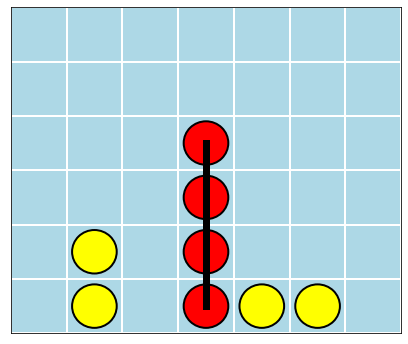

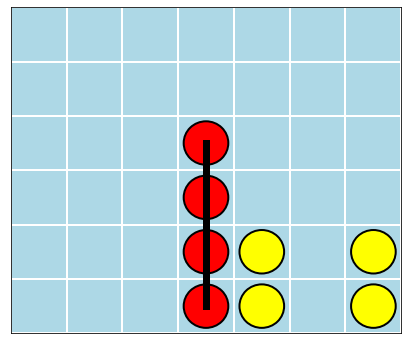

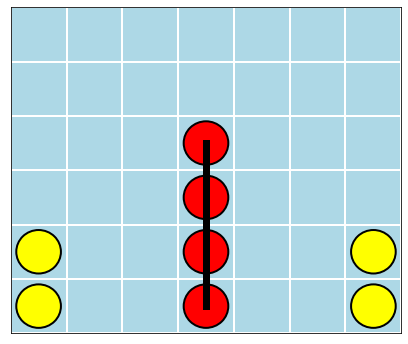

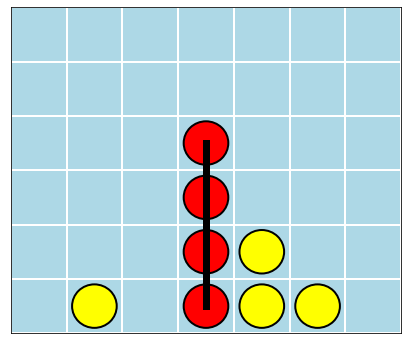

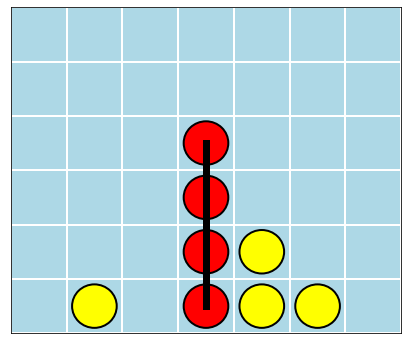

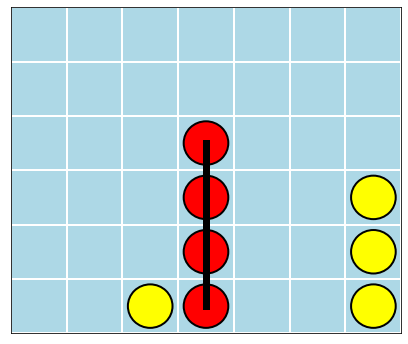

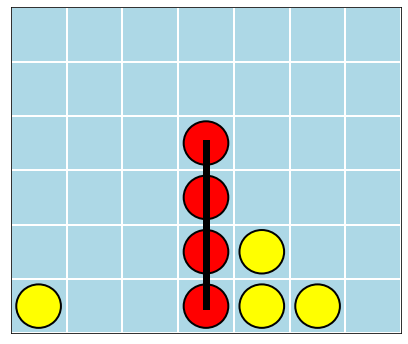

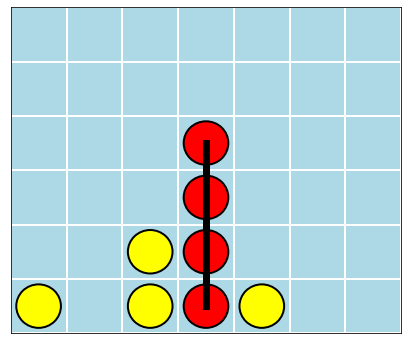

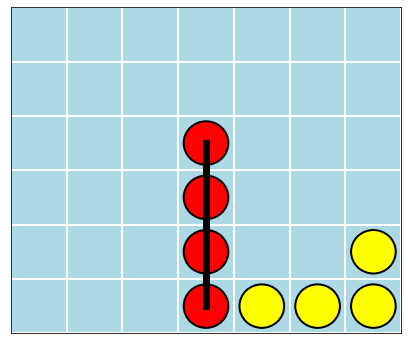

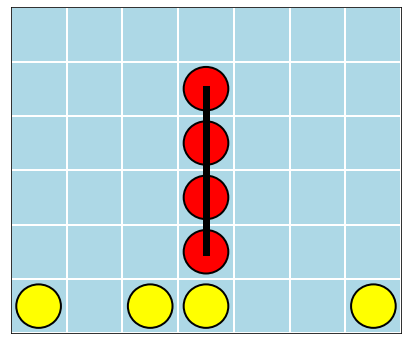

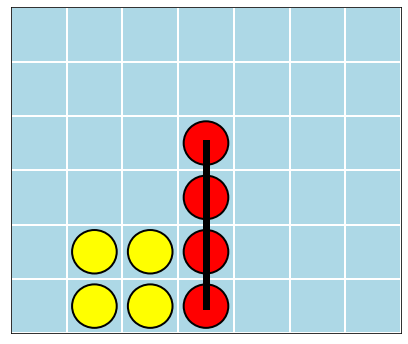

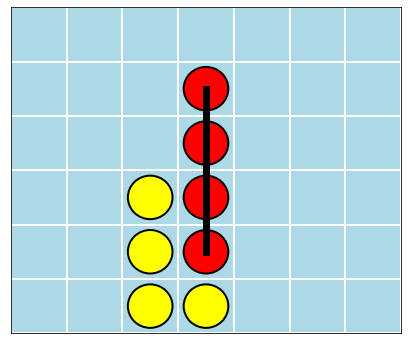

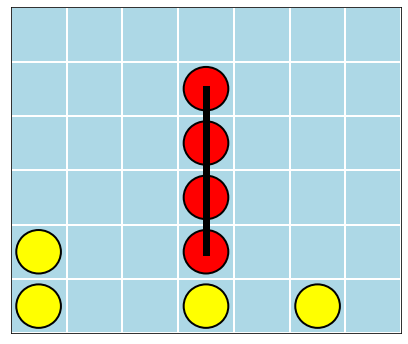

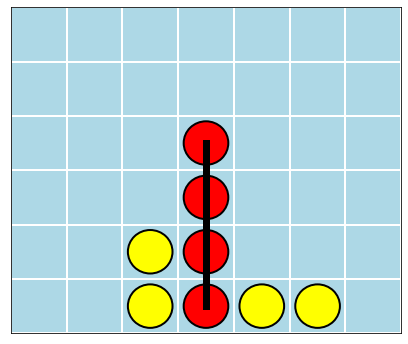

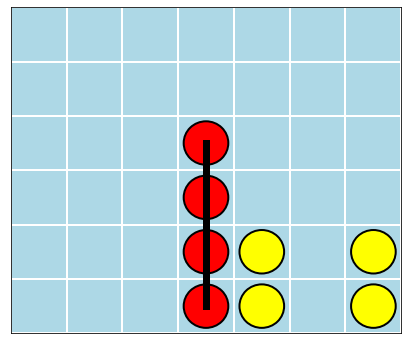

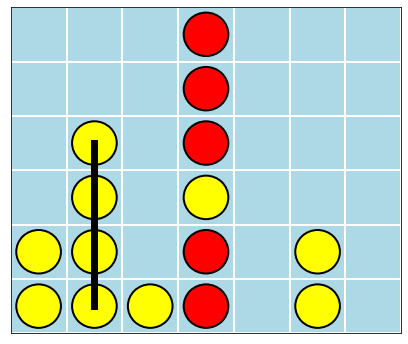

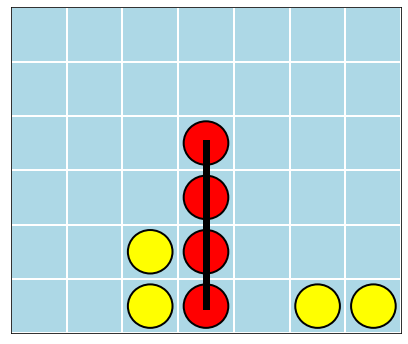

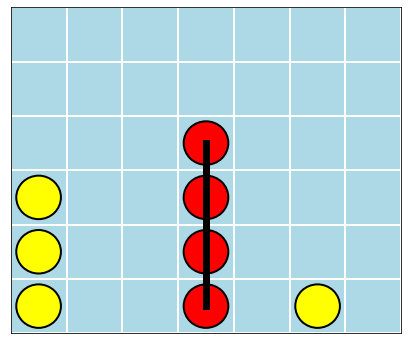

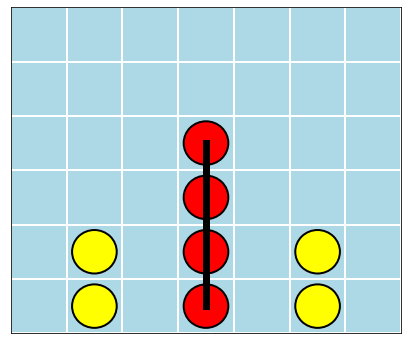

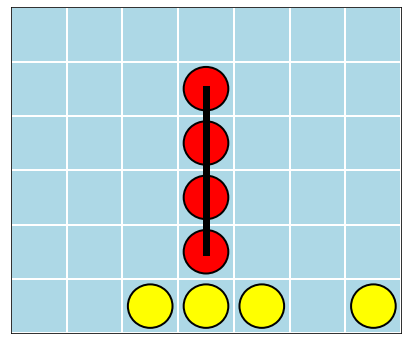

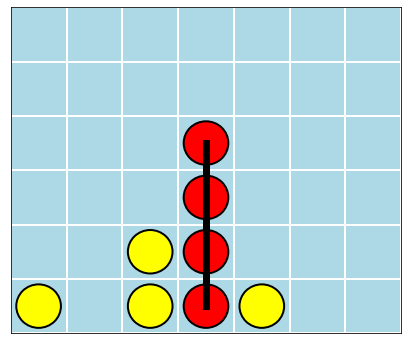

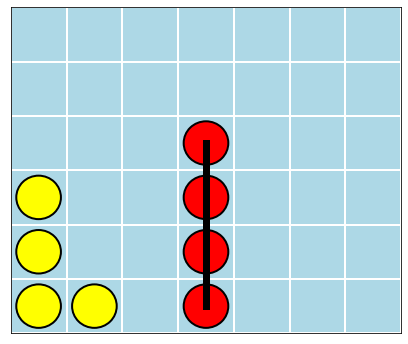

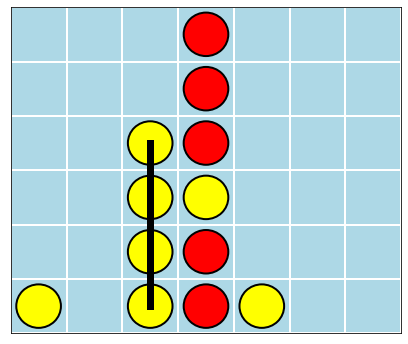

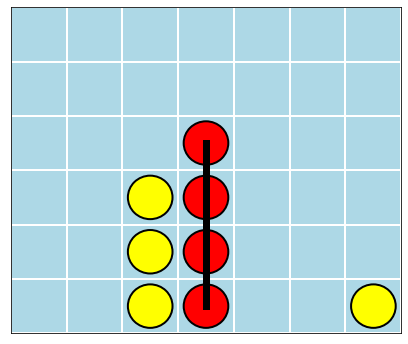

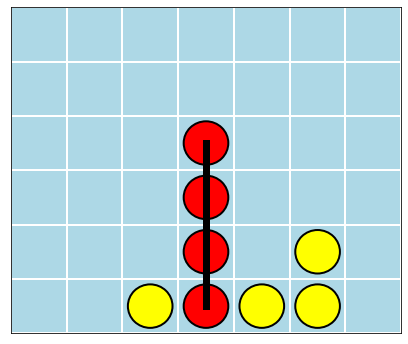

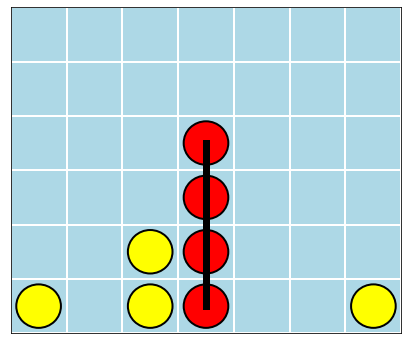

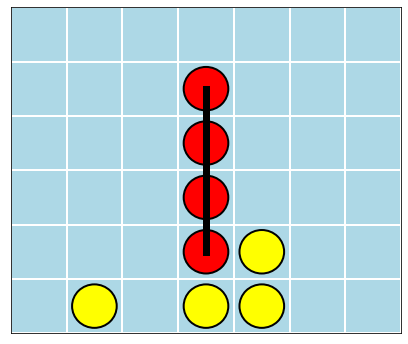

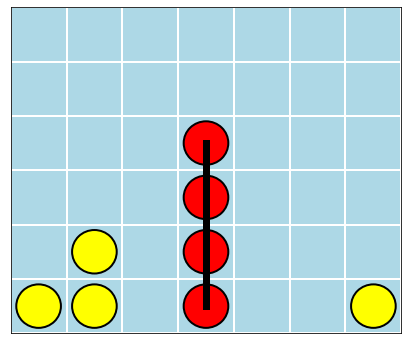

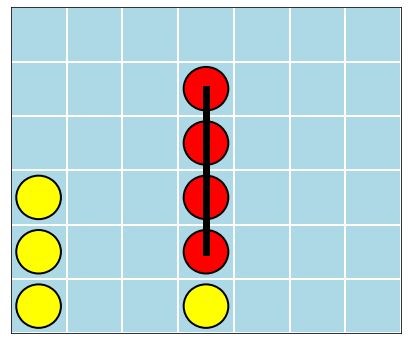

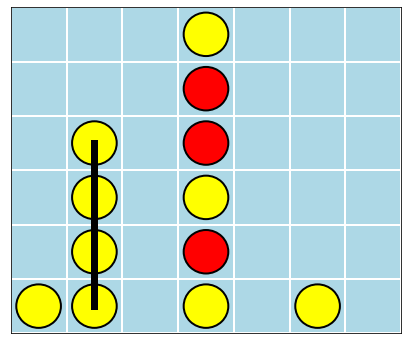

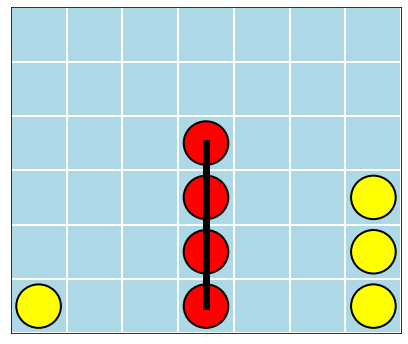

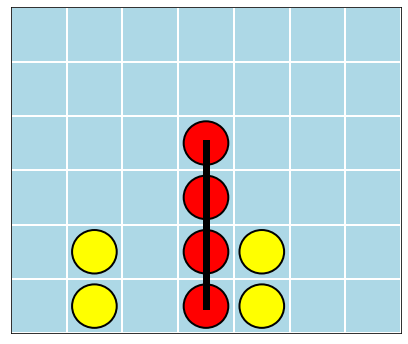

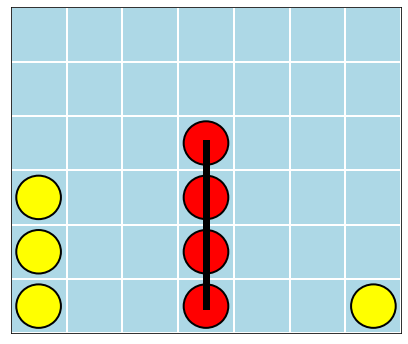

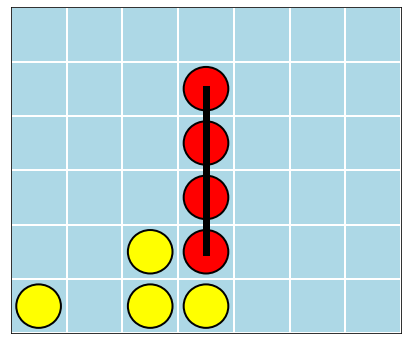

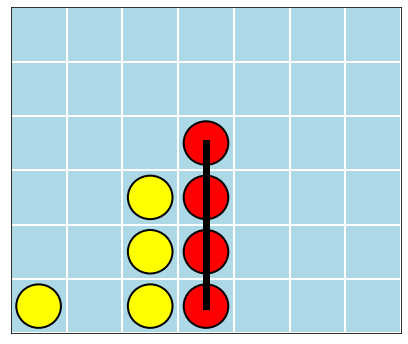

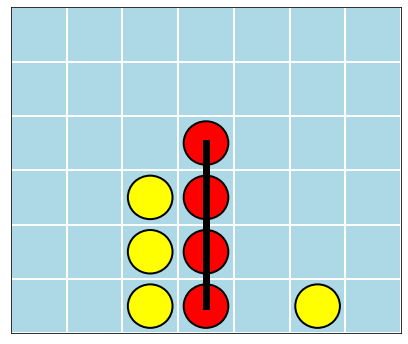

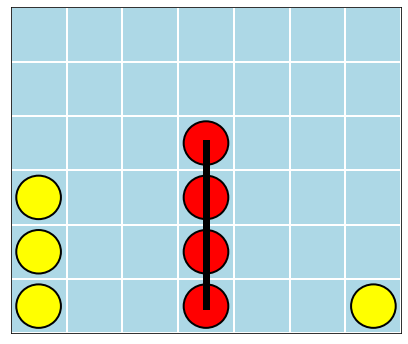

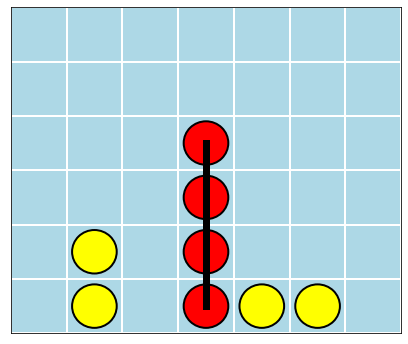

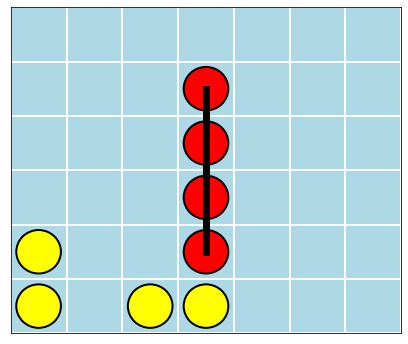

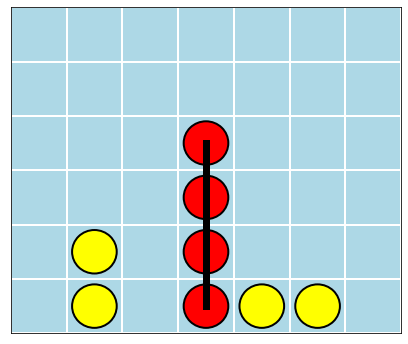

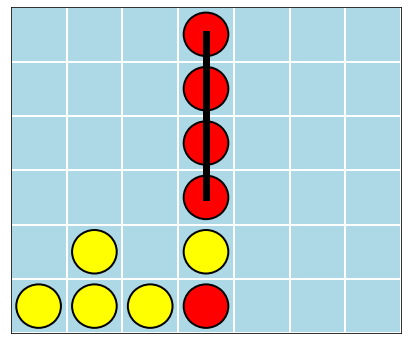

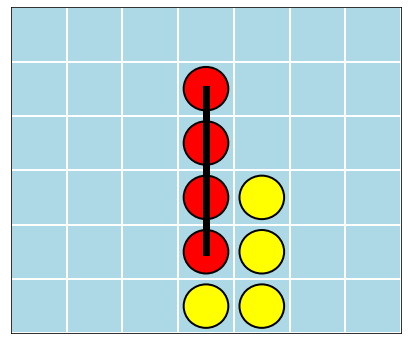

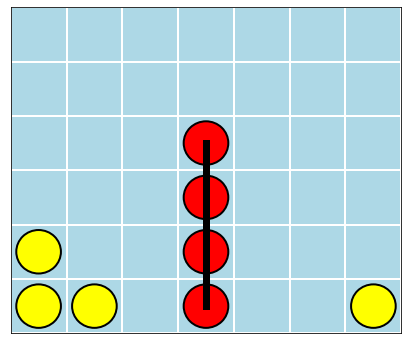

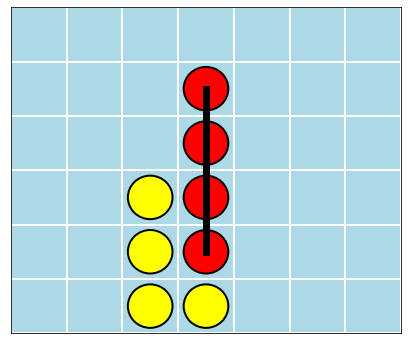

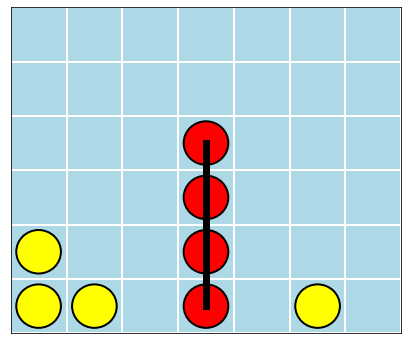

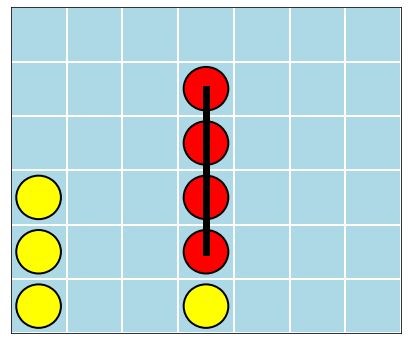

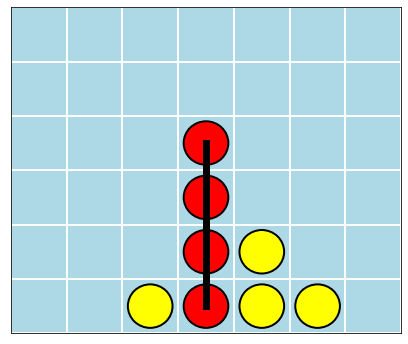

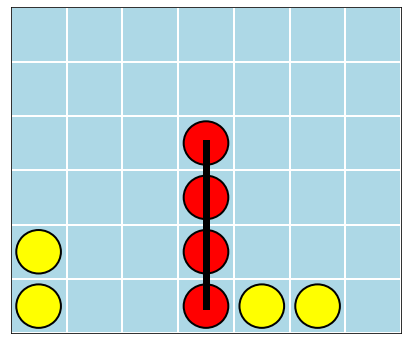

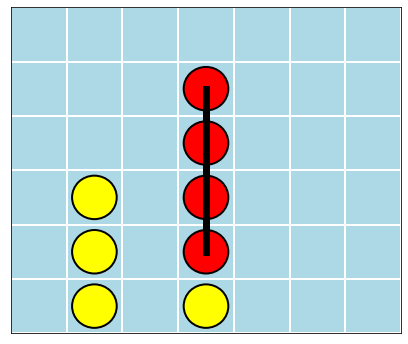

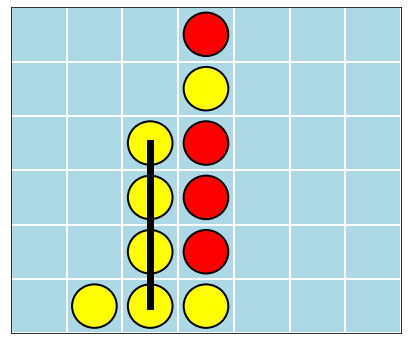

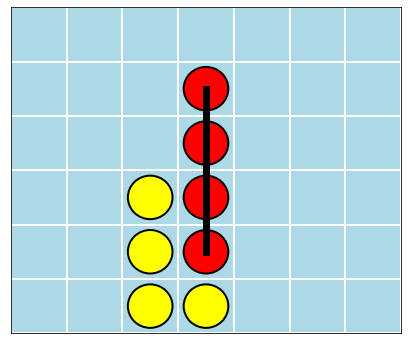

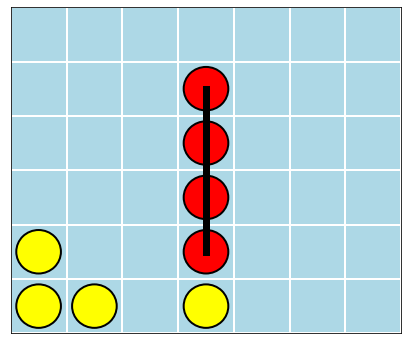

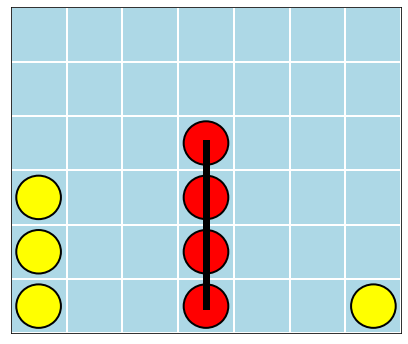

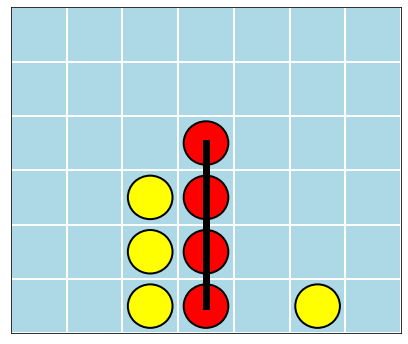

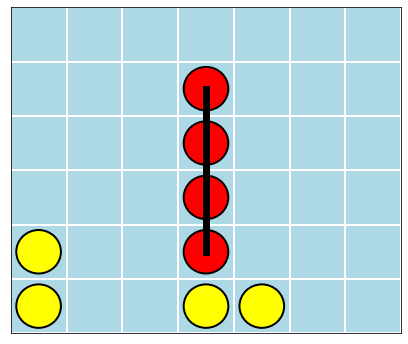

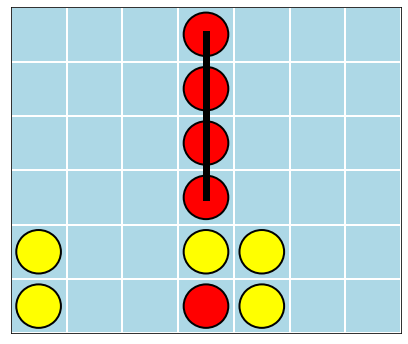

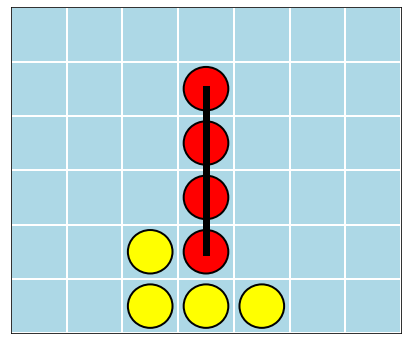

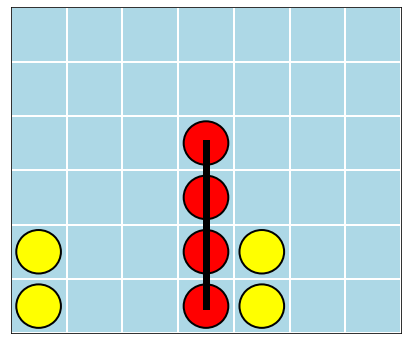

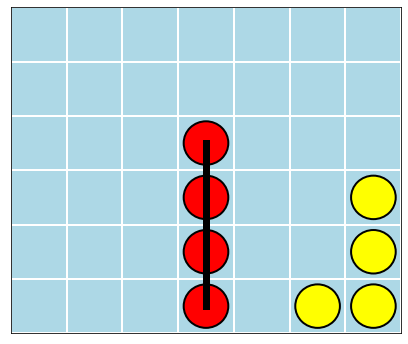

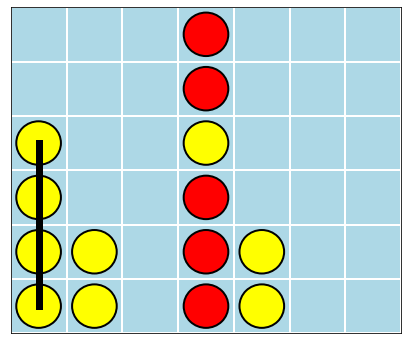

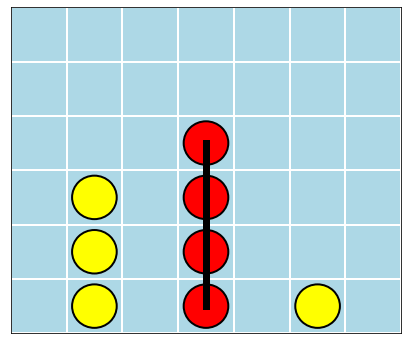

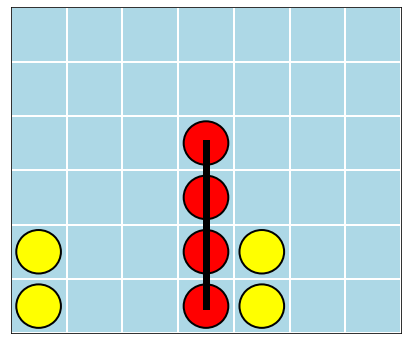

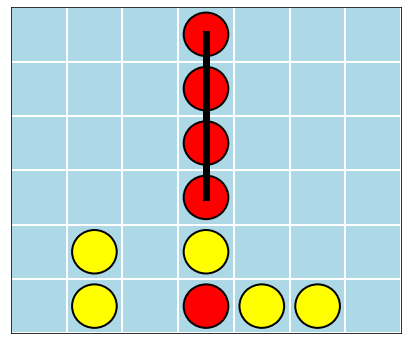

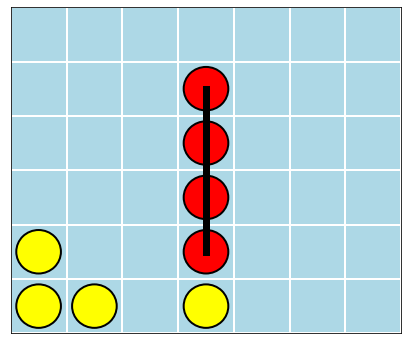

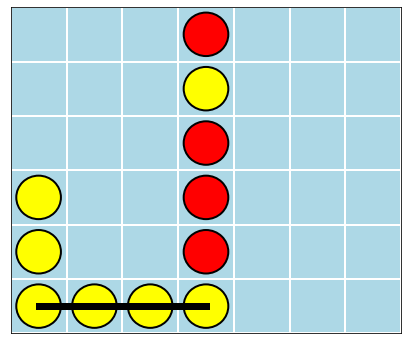

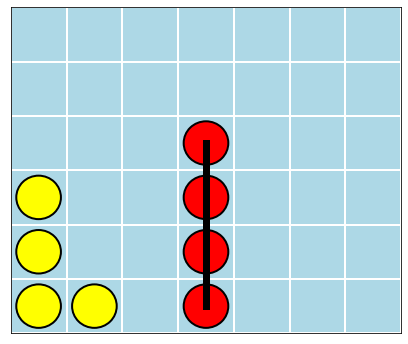

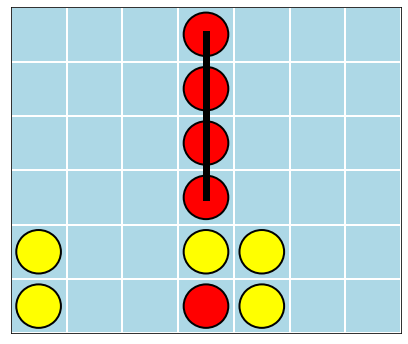

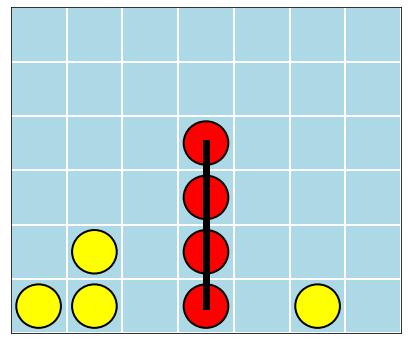

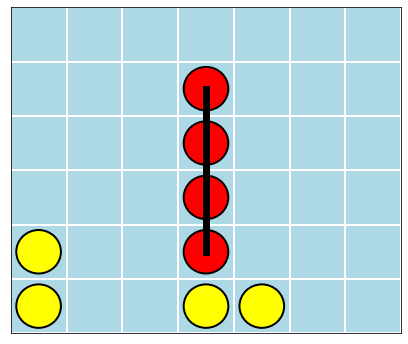

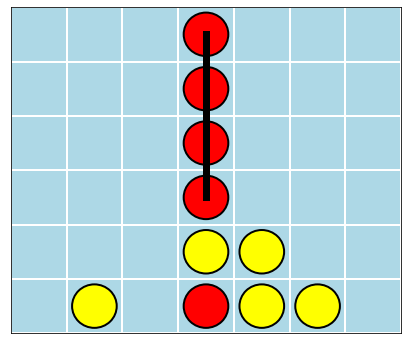

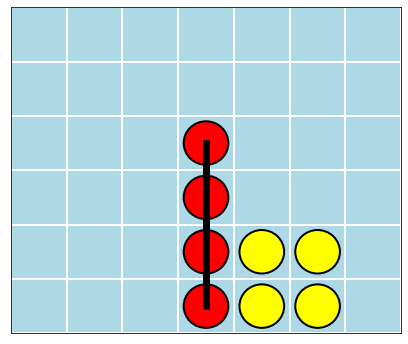

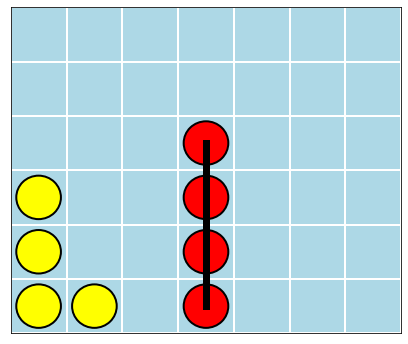

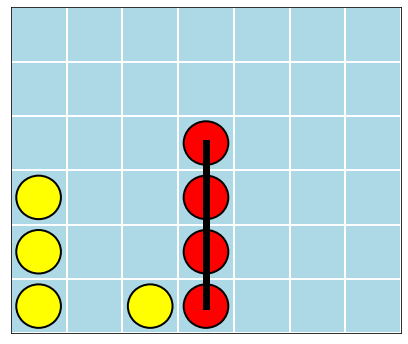

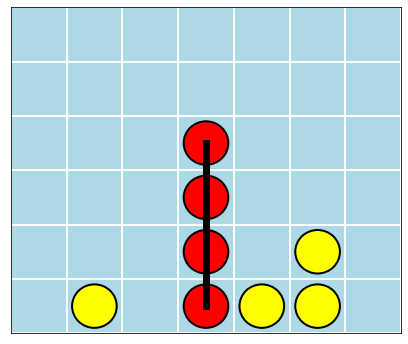

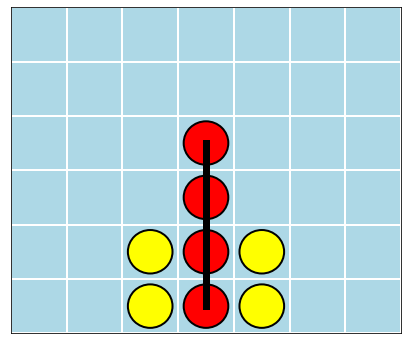

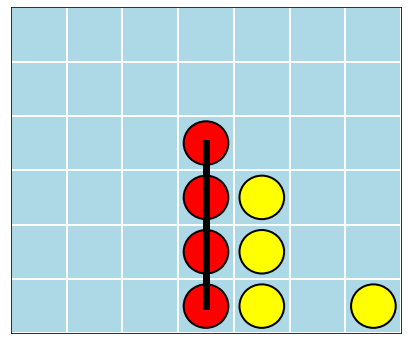

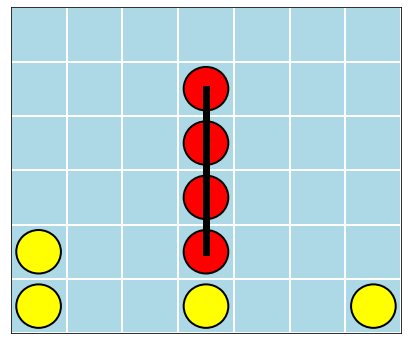

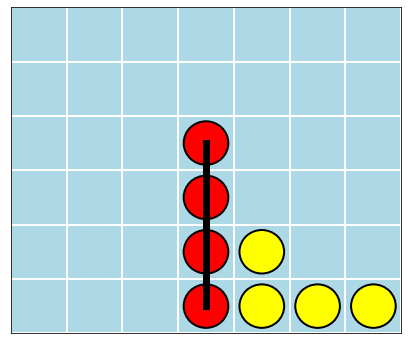

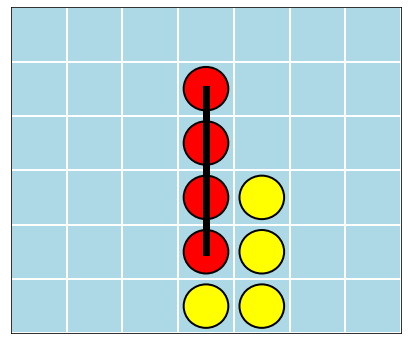

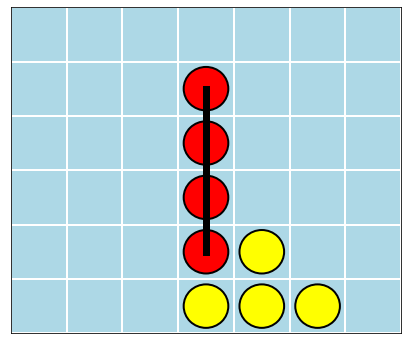

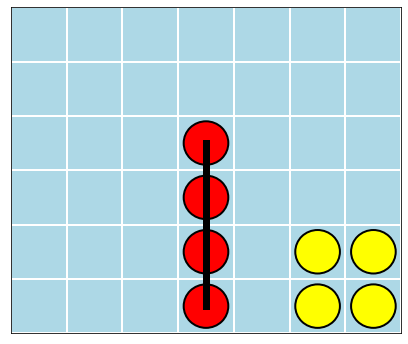

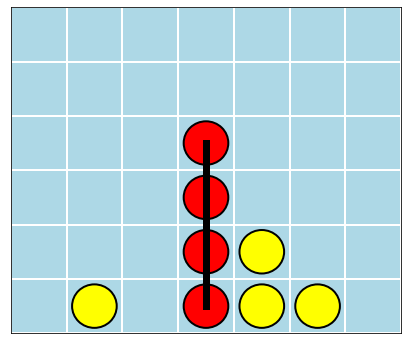

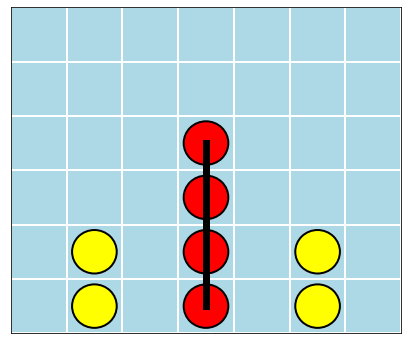

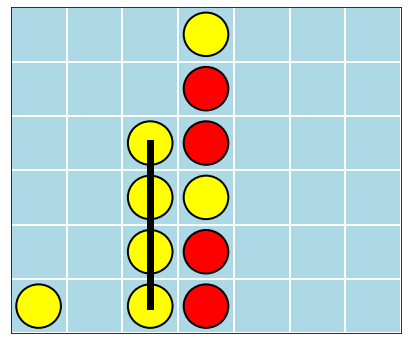

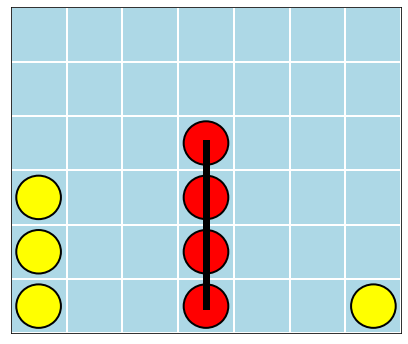

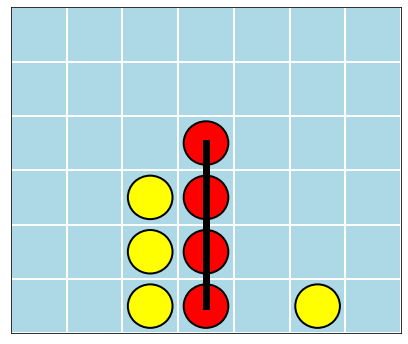

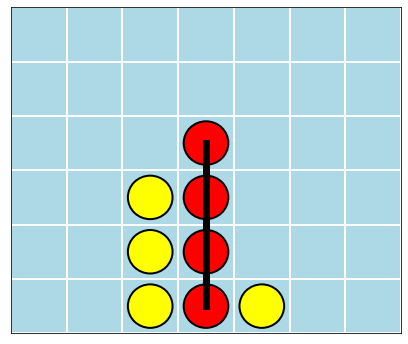

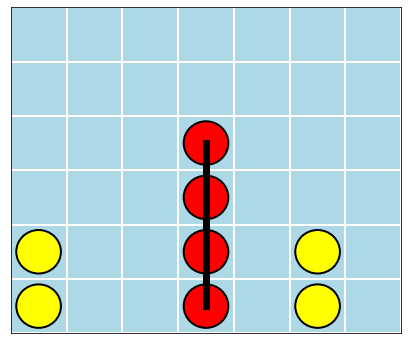

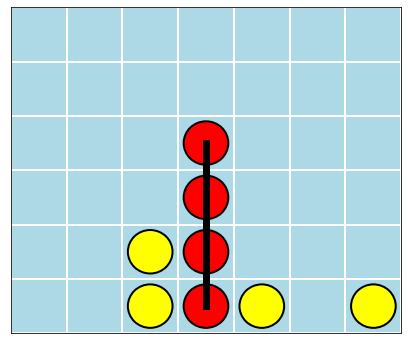

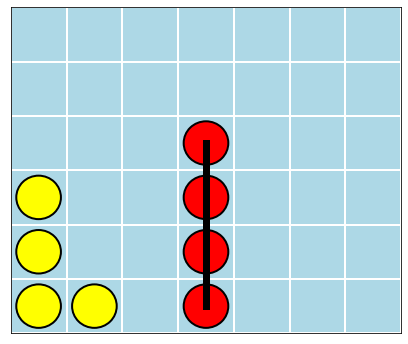

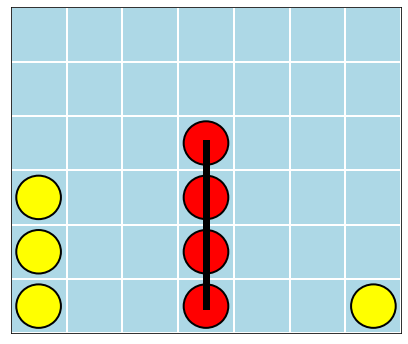

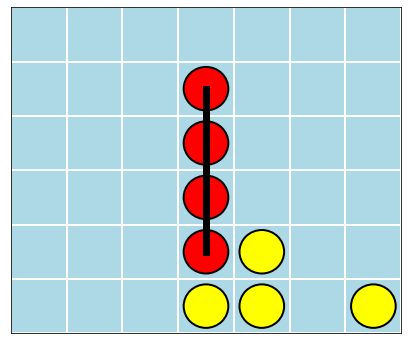

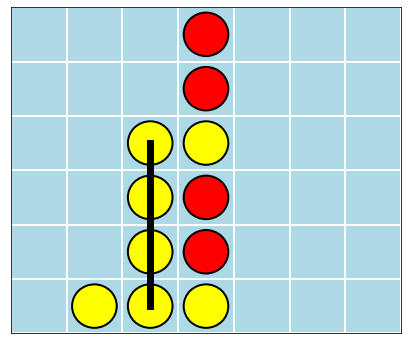

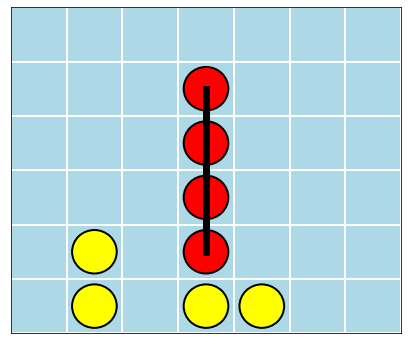

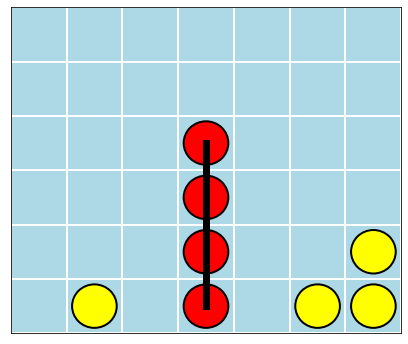

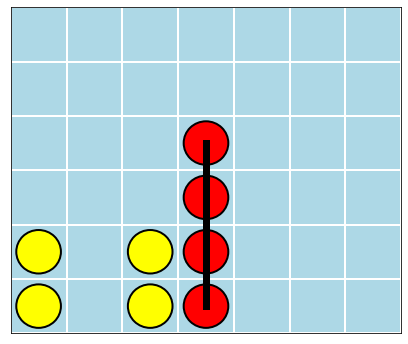

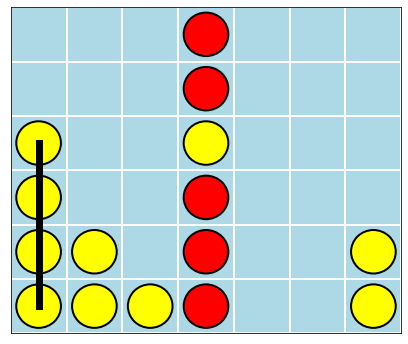

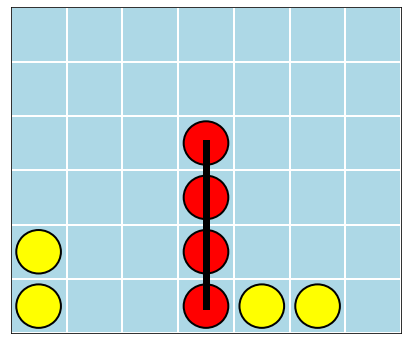

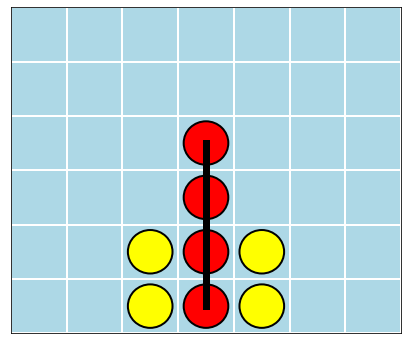

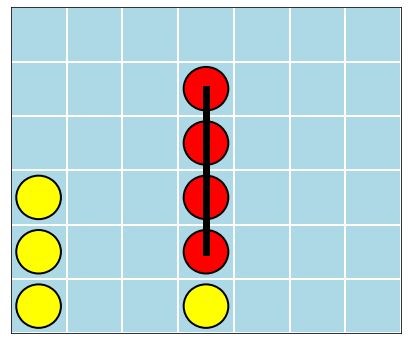

Score: Agent 9 - 91 Opponent. There were 0 Ties


In [40]:
env = Env()
opponent = MinimaxAgent(env, depth=2, epsilon=0.0, player=2)
transformer_utils.evaluate_model(model, opponent, 100, 2, True)